In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from finance_byu.rolling import roll_sum
from finance_byu.summarize import summary
from finance_byu.regtables import Regtable

# Initiations:

In [2]:
pd.options.display.max_rows = 100

# Read in the monthly CRSP data, clean, and set up features
stk = pd.read_csv('crsp_monthly.csv', parse_dates=['caldt'])
stk['mdt'] = stk['caldt'].values.astype('datetime64[M]')

stk['prc'] = stk['prc'].abs()
stk['me']  = stk.eval("prc*shr/1000.0").where(stk.eval("prc*shr > 1e-6")) 

stk['prclag'] = stk.groupby('permno')['prc'].shift()
stk['melag'] = stk.groupby('permno')['me'].shift()
stk

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,mdt,me,prclag,melag
0,10000,1986-01-31,68391610,OMFGA,10,3,3990,4.37500,NaN,1771.0,3680.0,1.0,1986-01-01,1.610000e+01,NaN,NaN
1,10000,1986-02-28,68391610,OMFGA,10,3,3990,3.25000,-0.257143,828.0,3680.0,1.0,1986-02-01,1.196000e+01,4.3750,1.610000e+01
2,10000,1986-03-31,68391610,OMFGA,10,3,3990,4.43750,0.365385,1078.0,3680.0,1.0,1986-03-01,1.633000e+01,3.2500,1.196000e+01
3,10000,1986-04-30,68391610,OMFGA,10,3,3990,4.00000,-0.098592,957.0,3793.0,1.0,1986-04-01,1.517200e+01,4.4375,1.633000e+01
4,10000,1986-05-30,68391610,OMFGA,10,3,3990,3.10938,-0.222656,1074.0,3793.0,1.0,1986-05-01,1.179388e+01,4.0000,1.517200e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004038,93436,2024-08-30,88160R10,TSLA,11,3,9999,214.11000,-0.077391,16108400.0,3194640.0,1.0,2024-08-01,6.840044e+05,232.0700,7.413801e+05
5004039,93436,2024-09-30,88160R10,TSLA,11,3,9999,261.63000,0.221942,16042100.0,3207000.0,1.0,2024-09-01,8.390474e+05,214.1100,6.840044e+05
5004040,93436,2024-10-31,88160R10,TSLA,11,3,9999,249.85000,-0.045025,19014300.0,3210060.0,1.0,2024-10-01,8.020335e+05,261.6300,8.390474e+05
5004041,93436,2024-11-29,88160R10,TSLA,11,3,9999,345.16000,0.381469,20821300.0,3210060.0,1.0,2024-11-01,1.107984e+06,249.8500,8.020335e+05


In [3]:
# Read in the dividends data, clean, and set up features
div = pd.read_csv('dividends_cash.csv', parse_dates=['dclrdt', 'exdt', 'paydt'])
div['mdt'] = div['paydt'].values.astype('datetime64[M]')
div = div[['permno','mdt','divamt']]
div

,permno,mdt,divamt
0,10001,1986-03-01,0.095
1,10001,1986-06-01,0.105
2,10001,1986-09-01,0.105
3,10001,1986-12-01,0.105
4,10001,1987-03-01,0.105
...,...,...,...
985382,93429,2023-12-01,0.550
985383,93429,2024-03-01,0.550
985384,93429,2024-06-01,0.550
985385,93429,2024-09-01,0.630


In [4]:
# Merge the data and lag 1 month to avoid counting the current month
stk = stk.merge(div,on=['permno','mdt'],how='left')
stk['div'] = stk['divamt'].notnull().astype(int)
    
stk['d12'] = (stk.groupby('permno')['div'].rolling(12).sum()
                     .reset_index(drop=True) )
stk['d12'] = stk.groupby('permno')['d12'].shift(1)
stk

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,shr,cumfacshr,mdt,me,prclag,melag,divamt,div,d12
0,10000,1986-01-31,68391610,OMFGA,10,3,3990,4.37500,NaN,1771.0,3680.0,1.0,1986-01-01,1.610000e+01,NaN,NaN,NaN,0,NaN
1,10000,1986-02-28,68391610,OMFGA,10,3,3990,3.25000,-0.257143,828.0,3680.0,1.0,1986-02-01,1.196000e+01,4.3750,1.610000e+01,NaN,0,NaN
2,10000,1986-03-31,68391610,OMFGA,10,3,3990,4.43750,0.365385,1078.0,3680.0,1.0,1986-03-01,1.633000e+01,3.2500,1.196000e+01,NaN,0,NaN
3,10000,1986-04-30,68391610,OMFGA,10,3,3990,4.00000,-0.098592,957.0,3793.0,1.0,1986-04-01,1.517200e+01,4.4375,1.633000e+01,NaN,0,NaN
4,10000,1986-05-30,68391610,OMFGA,10,3,3990,3.10938,-0.222656,1074.0,3793.0,1.0,1986-05-01,1.179388e+01,4.0000,1.517200e+01,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041301,93436,2024-08-30,88160R10,TSLA,11,3,9999,214.11000,-0.077391,16108400.0,3194640.0,1.0,2024-08-01,6.840044e+05,232.0700,7.413801e+05,NaN,0,0.0
5041302,93436,2024-09-30,88160R10,TSLA,11,3,9999,261.63000,0.221942,16042100.0,3207000.0,1.0,2024-09-01,8.390474e+05,214.1100,6.840044e+05,NaN,0,0.0
5041303,93436,2024-10-31,88160R10,TSLA,11,3,9999,249.85000,-0.045025,19014300.0,3210060.0,1.0,2024-10-01,8.020335e+05,261.6300,8.390474e+05,NaN,0,0.0
5041304,93436,2024-11-29,88160R10,TSLA,11,3,9999,345.16000,0.381469,20821300.0,3210060.0,1.0,2024-11-01,1.107984e+06,249.8500,8.020335e+05,NaN,0,0.0


In [5]:
# Calculate any initiations in the last 5 years prior to last year  
stk['div60to13'] = (stk.groupby('permno')['div'].rolling(48,12).sum().reset_index(drop=True))

stk['div60to13'] = stk.groupby('permno')['div60to13'].shift(13)

stk['port'] = stk.eval("d12 > 0 and div60to13 == 0").astype(int) 
    
stk = (stk.query("10 <= shrcd <= 11 and melag == melag and "
                 "prclag > 4.999 and ret == ret").reset_index(drop=True))
stk

,permno,caldt,cusip,ticker,shrcd,excd,siccd,prc,ret,vol,...,cumfacshr,mdt,me,prclag,melag,divamt,div,d12,div60to13,port
0,10001,1986-02-28,39040610,GFGC,11,3,4920,6.2500,0.020408,1067.0,...,3.0,1986-02-01,6.156250e+00,6.1250,6.033125e+00,NaN,0,NaN,NaN,0
1,10001,1986-03-31,39040610,GFGC,11,3,4920,6.3125,0.025200,335.0,...,3.0,1986-03-01,6.217812e+00,6.2500,6.156250e+00,0.095,1,NaN,NaN,0
2,10001,1986-04-30,39040610,GFGC,11,3,4920,6.3750,0.009901,225.0,...,3.0,1986-04-01,6.279375e+00,6.3125,6.217812e+00,NaN,0,NaN,NaN,0
3,10001,1986-05-30,39040610,GFGC,11,3,4920,6.3125,-0.009804,217.0,...,3.0,1986-05-01,6.217812e+00,6.3750,6.279375e+00,NaN,0,NaN,NaN,0
4,10001,1986-06-30,39040610,GFGC,11,3,4920,6.1250,-0.013069,238.0,...,3.0,1986-06-01,6.033125e+00,6.3125,6.217812e+00,0.105,1,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888510,93436,2024-08-30,88160R10,TSLA,11,3,9999,214.1100,-0.077391,16108400.0,...,1.0,2024-08-01,6.840044e+05,232.0700,7.413801e+05,NaN,0,0.0,0.0,0
2888511,93436,2024-09-30,88160R10,TSLA,11,3,9999,261.6300,0.221942,16042100.0,...,1.0,2024-09-01,8.390474e+05,214.1100,6.840044e+05,NaN,0,0.0,0.0,0
2888512,93436,2024-10-31,88160R10,TSLA,11,3,9999,249.8500,-0.045025,19014300.0,...,1.0,2024-10-01,8.020335e+05,261.6300,8.390474e+05,NaN,0,0.0,0.0,0
2888513,93436,2024-11-29,88160R10,TSLA,11,3,9999,345.1600,0.381469,20821300.0,...,1.0,2024-11-01,1.107984e+06,249.8500,8.020335e+05,NaN,0,0.0,0.0,0


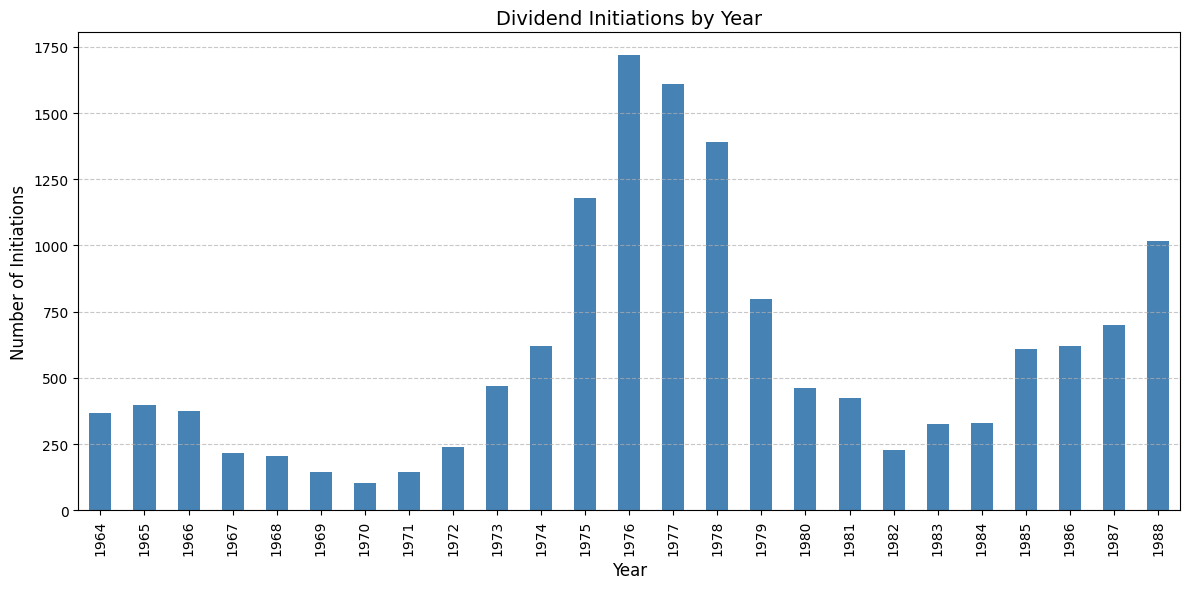

In [6]:
# Restrict data to sample period
stk_64to88 = stk[(stk['caldt'] >= '1964-01-01')&(stk['caldt'] <= '1988-12-31')]

# Count and plot initiations by year to check
init_counts = stk_64to88.groupby(stk_64to88['caldt'].dt.year)['port'].sum()

plt.figure(figsize=(12, 6))
init_counts.plot(kind='bar', color='steelblue')
plt.title('Dividend Initiations by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Initiations', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Calculate the equal weight portfolios
ew = (stk_64to88.groupby(['caldt','port'])['ret'].mean().unstack(level='port')
          .rename('p{:.0f}'.format,axis='columns')*100)    

# Get summary statistics for equal weight and print the results
ew_summ = summary(ew)

print("Equal-Weight Portfolios")
ew_summ.round(3)

Equal-Weight Portfolios


port,p0,p1
count,300.000,300.000
mean,1.199,1.898
std,5.717,7.545
tstat,3.634,4.358
pval,0.000,0.000
min,-27.279,-28.339
25%,-1.860,-2.087
50%,1.437,1.764
75%,4.797,7.240
max,20.957,24.186


In [8]:
# Restrict data to sample period
stk['rme'] = stk['ret']*stk['melag']
stk_64to88 = stk[(stk['caldt'] >= '1964-01-01')&(stk['caldt'] <= '1988-12-31')]

# Get summary statistics for value weight and print the results
vw = ((stk_64to88.groupby(['caldt','port'])['rme'].sum()/
        stk_64to88.groupby(['caldt','port'])['melag'].sum()).unstack(level='port')
        .rename('p{:.0f}'.format,axis='columns')*100)    
vw_summ = summary(vw)
print("Value-Weight Portfolios")
vw_summ.round(3)

Value-Weight Portfolios


port,p0,p1
count,300.000,300.000
mean,0.884,1.429
std,4.575,8.765
tstat,3.347,2.824
pval,0.001,0.005
min,-22.503,-30.646
25%,-1.697,-3.117
50%,0.895,1.551
75%,4.132,6.379
max,16.723,32.472


In [9]:
# Now test the model with the CAPM and Fama French models
names = ew.columns.tolist()
    
# Read factors and ensure date parsing
fac = pd.read_csv("https://diether.org/prephd/14-factors.csv",parse_dates=['caldt'])
fac['caldt'] = fac['caldt'].values.astype('datetime64[M]')  # Match monthly frequency
fac = fac.set_index('caldt')
    
# Ensure ew has a proper datetime index
ew.index = ew.index.values.astype('datetime64[M]')

# Perform the join
ew = ew.join(fac, how='inner')

# Now continue with your analysis
ew[names] = ew[names].sub(ew['rf'], axis=0)
ew['spr'] = ew[names[-1]] - ew['p0']
    
summ = summary(ew[names + ['spr']])        
fm = [smf.ols(f'{y} ~ exmkt + smb + hml + umd', data=ew).fit()
        for y in names + ['spr']]
    
print("Equal-Weight Portfolios")
summ.round(3)

Equal-Weight Portfolios


,p0,p1,spr
count,300.000,300.000,300.000
mean,0.645,1.344,0.699
std,5.741,7.566,2.964
tstat,1.945,3.076,4.083
pval,0.053,0.002,0.000
min,-27.879,-28.939,-9.143
25%,-2.492,-2.563,-0.987
50%,1.026,1.230,0.467
75%,4.171,6.724,2.450
max,20.377,23.756,12.224


In [10]:
# Show the regression results for the models
reg_table = Regtable(fm)
reg_table.render()

,p0,p1,spr
Intercept,-0.019,0.589,0.609
,(-0.55),(3.67),(3.85)
exmkt,0.955,1.088,0.134
,(115.46),(28.93),(3.60)
smb,0.809,1.120,0.311
,(66.18),(20.13),(5.67)
hml,0.106,-0.093,-0.199
,(7.79),(-1.50),(-3.26)
umd,-0.012,0.033,0.044
,(-1.21),(0.75),(1.03)


# Omissions

Note the logic here is similar to before, but now all we have to do is perform a count on the number of dividend events in the prior period and if it is bigger than the current period (ex quarterly dividends in the last year should imply that the year should have 4 payouts and if there are only 3 in this year) then there was an omission somewhere 

In [11]:
# Calculate dividend omissions
# A company is considered to have omitted dividends if it had dividends in the past year but not in the current year
stk['div_prev12'] = (stk.groupby('permno')['div'].rolling(12).sum()
                      .reset_index(drop=True))
stk['div_prev12'] = stk.groupby('permno')['div_prev12'].shift(1)

# Create omission flag (had dividends in past year but none in current year)
stk['omit'] = stk.eval("div_prev12 > 0 and d12 == 0").astype(int)

# Filter data as before
stk = (stk.query("10 <= shrcd <= 11 and melag == melag and "
                 "prclag > 4.999 and ret == ret").reset_index(drop=True))

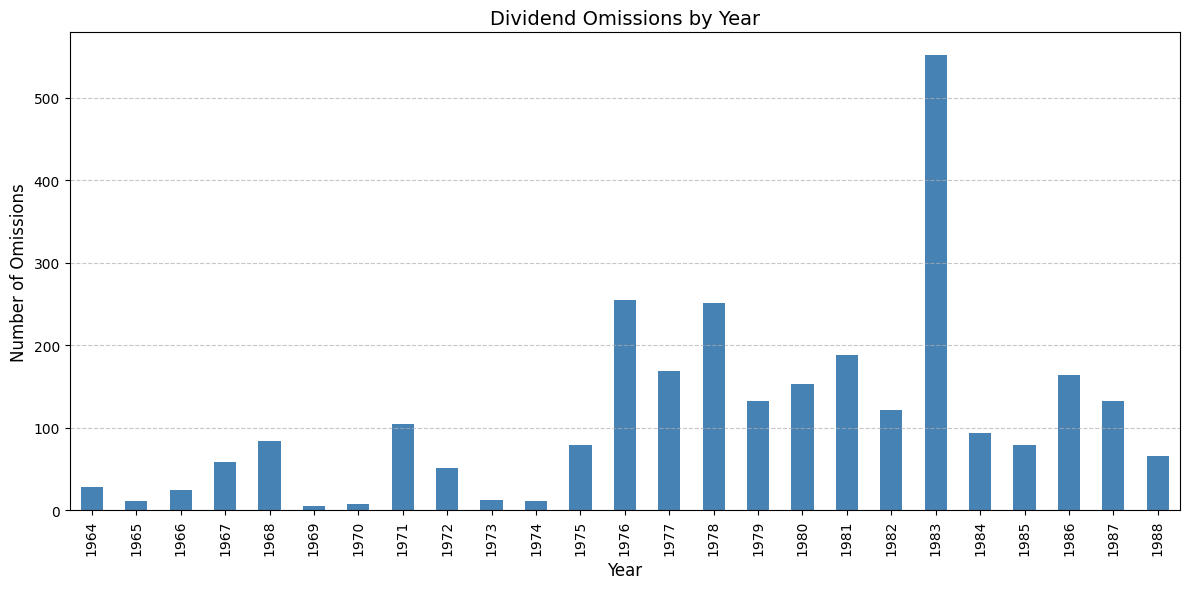

In [12]:
# Restrict data to sample period
stk_64to88 = stk[(stk['caldt'] >= '1964-01-01')&(stk['caldt'] <= '1988-12-31')]

# Count and plot omissions by year to check
omit_counts = stk_64to88.groupby(stk_64to88['caldt'].dt.year)['omit'].sum()

plt.figure(figsize=(12, 6))
omit_counts.plot(kind='bar', color='steelblue')
plt.title('Dividend Omissions by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Omissions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
# Equal-weight portfolios for omissions
ew_omit = (stk_64to88.groupby(['caldt','omit'])['ret'].mean().unstack(level='omit')
          .rename('p{:.0f}'.format,axis='columns')*100)

# Print summary statistics
print("\nEqual-Weight Omission Portfolios")
summary(ew_omit).round(3)


Equal-Weight Omission Portfolios


omit,p0,p1
count,300.000,265.000
mean,1.212,0.987
std,5.732,10.122
tstat,3.661,1.588
pval,0.000,0.114
min,-27.282,-32.419
25%,-1.830,-4.899
50%,1.464,-0.250
75%,4.830,6.458
max,20.940,39.286


In [14]:
# Restrict data to sample period
stk['rme'] = stk['ret']*stk['melag']
stk_64to88 = stk[(stk['caldt'] >= '1964-01-01')&(stk['caldt'] <= '1988-12-31')]

# Value-weight portfolios for omissions
vw_omit = ((stk_64to88.groupby(['caldt','omit'])['rme'].sum()/
            stk_64to88.groupby(['caldt','omit'])['melag'].sum()).unstack(level='omit')
            .rename('p{:.0f}'.format,axis='columns')*100)

print("\nValue-Weight Omission Portfolios")
summary(vw_omit).round(3)


Value-Weight Omission Portfolios


omit,p0,p1
count,300.000,265.000
mean,0.887,0.709
std,4.584,11.210
tstat,3.352,1.029
pval,0.001,0.304
min,-22.545,-34.276
25%,-1.702,-5.581
50%,0.895,-0.811
75%,4.129,7.384
max,16.792,39.286


In [15]:
# Factor model analysis for omissions
ew_omit.index = ew_omit.index.values.astype('datetime64[M]')
ew_omit = ew_omit.join(fac, how='inner')
ew_omit[['p0','p1']] = ew_omit[['p0','p1']].sub(ew_omit['rf'], axis=0)
ew_omit['spr'] = ew_omit['p1'] - ew_omit['p0']

# Run factor regressions
fm_omit = [smf.ols(f'{y} ~ exmkt + smb + hml + umd', data=ew_omit).fit()
          for y in ['p0','p1','spr']]

# Show results
print("\nOmission Portfolios Factor Model Results")
Regtable(fm_omit).render()


Omission Portfolios Factor Model Results


,p0,p1,spr
Intercept,-0.009,-0.671,-0.698
,(-0.27),(-1.33),(-1.41)
exmkt,0.956,0.967,0.022
,(117.24),(8.08),(0.19)
smb,0.812,1.381,0.567
,(67.33),(7.43),(3.11)
hml,0.105,0.141,0.050
,(7.76),(0.71),(0.25)
umd,-0.010,-0.057,-0.042
,(-1.04),(-0.41),(-0.30)


# Extentions

We should just extend this by testing out of sample, but also note that because we have done this with tradable securities and not just buy and hold this is already an extention inherently, but to extend further, we should do more out of sample past when they finished testing to.

In [16]:
# For extensions, we can test in different subperiods

# Split sample into early and late periods
split_date = '2005-01-01'
early = stk[stk['caldt'] < split_date]
late = stk[stk['caldt'] >= split_date]

# Repeat analysis for each subperiod
def analyze_subperiod(data, name):
    # Initiation analysis
    ew_init = (data.groupby(['caldt','port'])['ret'].mean().unstack()*100)
    # Omission analysis
    ew_omit = (data.groupby(['caldt','omit'])['ret'].mean().unstack()*100)
    
    print(f"\n{name} Period Results")
    print("Initiations:")
    print(summary(ew_init).round(3))
    print("\nOmissions:")
    print(summary(ew_omit).round(3))

In [17]:
analyze_subperiod(early, "Early")


Early Period Results
Initiations:
port         0        1
count  948.000  927.000
mean     1.111    1.812
std      6.559    9.231
tstat    5.214    5.976
pval     0.000    0.000
min    -30.908  -34.871
25%     -1.949   -2.092
50%      1.580    1.902
75%      4.454    5.856
max     44.215  129.667

Omissions:
omit         0        1
count  948.000  708.000
mean     1.120    1.254
std      6.552   11.445
tstat    5.261    2.915
pval     0.000    0.004
min    -30.949  -32.774
25%     -1.958   -5.363
50%      1.567    0.698
75%      4.438    6.674
max     43.835   73.750


In [18]:
analyze_subperiod(late, "Late")


Late Period Results
Initiations:
port         0        1
count  240.000  240.000
mean     0.770    0.940
std      5.374    6.007
tstat    2.220    2.425
pval     0.027    0.016
min    -21.524  -29.002
25%     -2.016   -2.644
50%      1.205    1.677
75%      4.059    4.251
max     17.958   26.039

Omissions:
omit         0        1
count  240.000  233.000
mean     0.773    0.627
std      5.372   10.331
tstat    2.228    0.926
pval     0.027    0.356
min    -21.603  -34.426
25%     -2.007   -4.565
50%      1.204    0.616
75%      4.070    6.332
max     17.990   38.226


In [19]:
# Compare in sample with out of sample
after = stk[stk['caldt'] >= '1989-01-01']
before = stk[stk['caldt'] < '1964-01-01']

In [20]:
analyze_subperiod(before, "Before Sample Period")


Before Sample Period Period Results
Initiations:
port         0        1
count  456.000  435.000
mean     1.023    1.843
std      7.651   11.624
tstat    2.854    3.307
pval     0.005    0.001
min    -30.908  -34.871
25%     -2.227   -2.957
50%      1.607    1.763
75%      4.360    6.455
max     44.215  129.667

Omissions:
omit         0        1
count  456.000  252.000
mean     1.031    1.853
std      7.635   14.537
tstat    2.883    2.024
pval     0.004    0.044
min    -30.949  -32.774
25%     -2.225   -7.317
50%      1.596    0.851
75%      4.380    7.746
max     43.835   73.750


In [21]:
analyze_subperiod(stk_64to88, "Sample Period")


Sample Period Period Results
Initiations:
port         0        1
count  300.000  300.000
mean     1.199    1.898
std      5.717    7.545
tstat    3.634    4.358
pval     0.000    0.000
min    -27.279  -28.339
25%     -1.860   -2.087
50%      1.437    1.764
75%      4.797    7.240
max     20.957   24.186

Omissions:
omit         0        1
count  300.000  265.000
mean     1.212    0.987
std      5.732   10.122
tstat    3.661    1.588
pval     0.000    0.114
min    -27.282  -32.419
25%     -1.830   -4.899
50%      1.464   -0.250
75%      4.830    6.458
max     20.940   39.286


In [22]:
analyze_subperiod(after, "After Sample Period")


After Sample Period Period Results
Initiations:
port         0        1
count  432.000  432.000
mean     0.953    1.236
std      5.107    5.255
tstat    3.878    4.889
pval     0.000    0.000
min    -21.524  -29.002
25%     -1.944   -1.747
50%      1.397    1.856
75%      4.112    4.275
max     17.958   26.039

Omissions:
omit         0        1
count  432.000  424.000
mean     0.957    0.719
std      5.100    9.371
tstat    3.899    1.581
pval     0.000    0.115
min    -21.603  -34.426
25%     -1.933   -4.615
50%      1.424    1.047
75%      4.143    5.805
max     17.990   38.226


In [23]:
# Count and Plot subperiods
def count_plot(data, name):
    omit_counts = data.groupby(data['caldt'].dt.year)['omit'].sum()
    plt.figure(figsize=(12, 6))
    omit_counts.plot(kind='bar', color='steelblue')
    plt.title(f'Dividend Omissions by Year - {names[i]}', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Omissions', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    plt.clf()

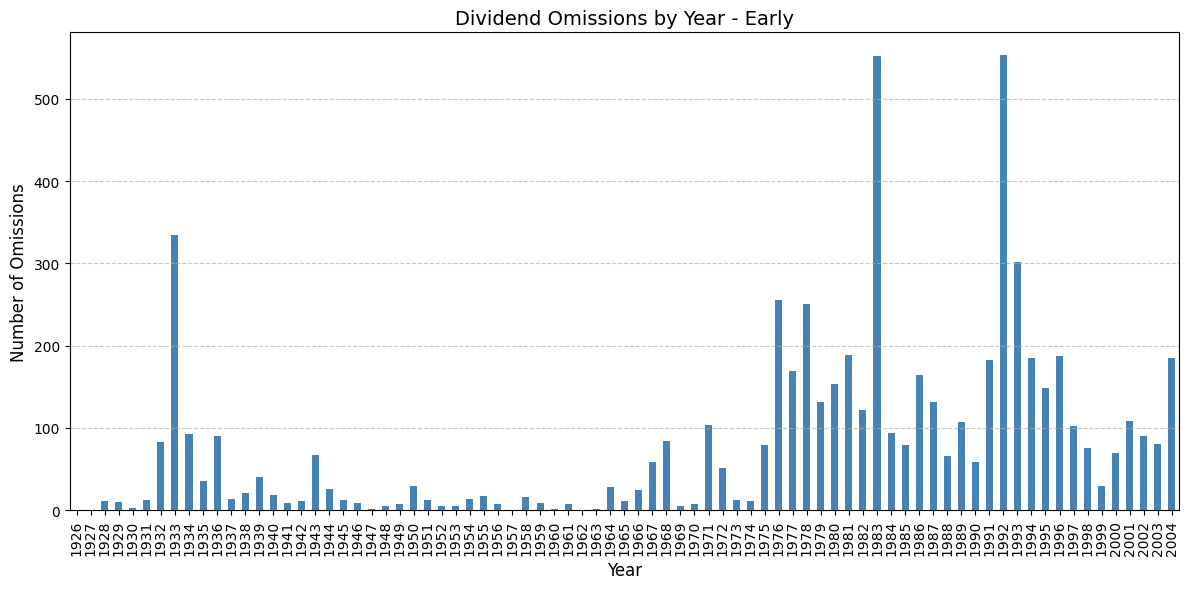

<Figure size 640x480 with 0 Axes>

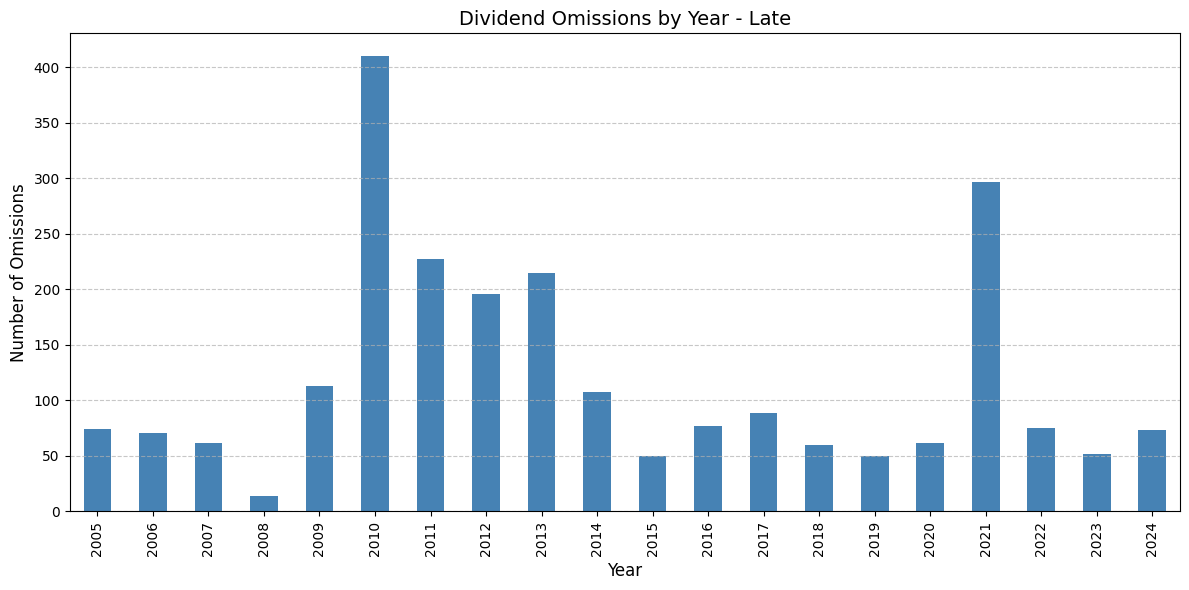

<Figure size 640x480 with 0 Axes>

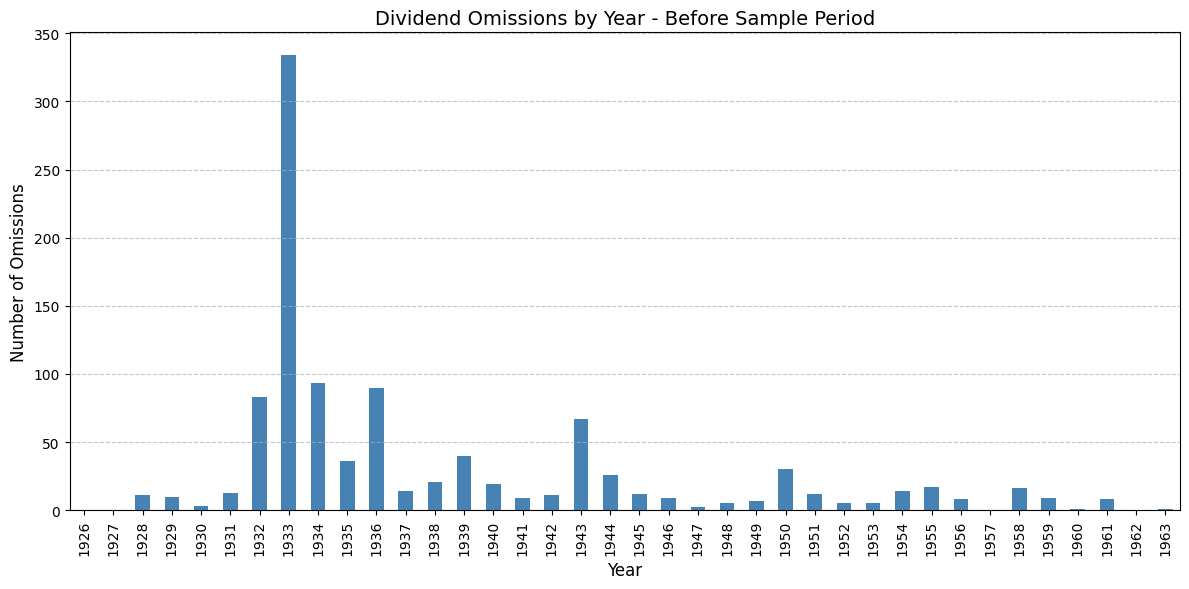

<Figure size 640x480 with 0 Axes>

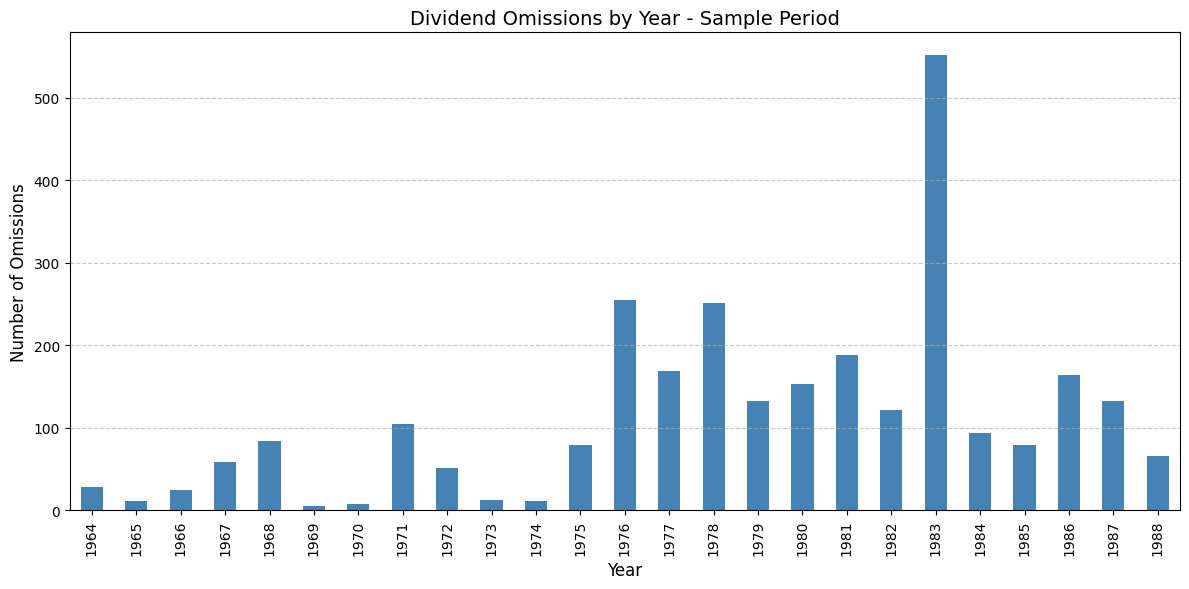

<Figure size 640x480 with 0 Axes>

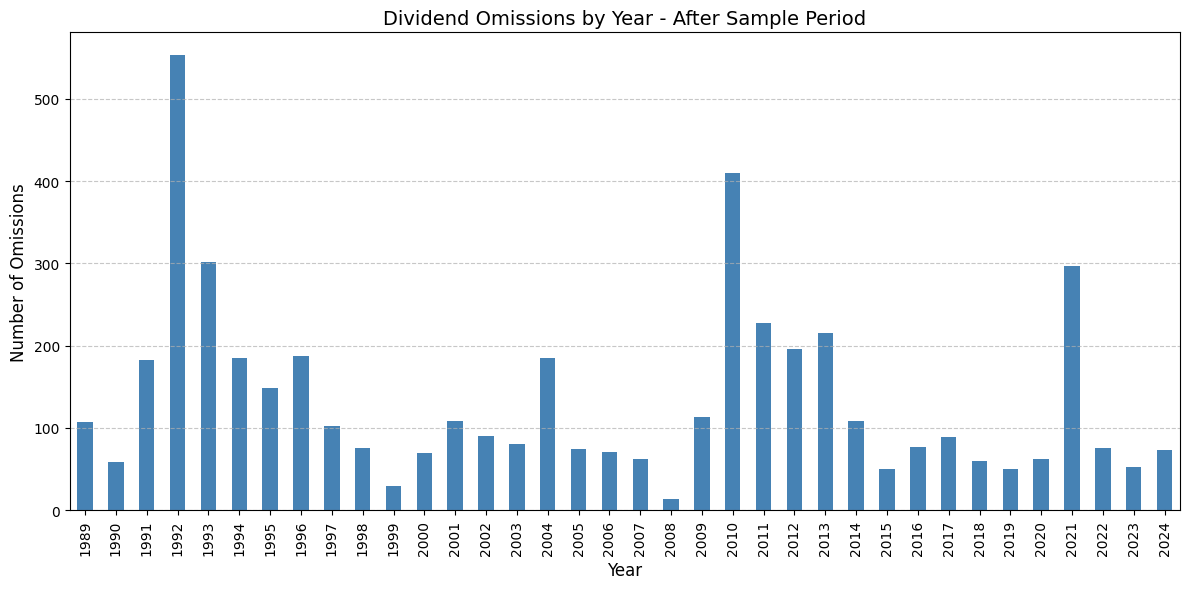

<Figure size 640x480 with 0 Axes>

In [24]:
periods = [early, late, before, stk_64to88, after]
names = ['Early', 'Late', 'Before Sample Period', 'Sample Period', 'After Sample Period']

for i in range(len(periods)):
    count_plot(periods[i], names[i])

In [28]:
# Test equal weight spread portfolios for each subperiod against Fama-French model
reg = {}
regnames = []

def form_port(data, name):
    init = (data.groupby(['caldt','port'])['ret'].mean().unstack(level='port')*100) 
    omit = (data.groupby(['caldt','omit'])['ret'].mean().unstack(level='omit')*100)
    init.index = init.index.values.astype('datetime64[M]')
    omit.index = omit.index.values.astype('datetime64[M]')
    init = init.join(fac, how='inner')
    omit = omit.join(fac, how='inner')
    init[[0, 1]] = init[[0, 1]].sub(init['rf'], axis=0)
    omit[[0, 1]] = omit[[0, 1]].sub(init['rf'], axis=0)
    init['spread'] = init[1]-init[0]
    omit['spread'] = omit[0]-omit[1]
    reg[f"{name}_init"] = smf.ols("spread ~ exmkt + smb + hml + umd", data=init).fit()
    reg[f"{name}_omit"] = smf.ols("spread ~ exmkt + smb + hml + umd", data=omit).fit()


for i in range(len(periods)):
    form_port(periods[i], names[i])
    regnames.append(f"{names[i]} initiations")
    regnames.append(f"{names[i]} omissions")


print("Spread Portfolios")
Regtable(list(reg.values()), regnames).render()

Spread Portfolios


,Early initiations,Early omissions,Late initiations,Late omissions,Before Sample Period initiations,Before Sample Period omissions,Sample Period initiations,Sample Period omissions,After Sample Period initiations,After Sample Period omissions
Intercept,0.401,0.694,0.125,0.372,0.401,0.340,0.609,0.698,0.231,0.600
,(2.12),(2.27),(0.85),(0.68),(1.09),(0.55),(3.85),(1.41),(2.13),(1.71)
exmkt,0.152,-0.128,0.056,-0.236,0.266,-0.153,0.134,-0.022,-0.024,-0.175
,(4.19),(-2.10),(1.57),(-1.74),(3.87),(-1.19),(3.60),(-0.19),(-0.93),(-2.07)
smb,0.102,-0.531,-0.145,-0.084,0.243,-0.427,0.311,-0.567,-0.140,-0.466
,(1.78),(-5.90),(-2.37),(-0.37),(2.10),(-2.42),(5.67),(-3.11),(-4.01),(-4.18)
hml,0.059,-0.360,0.202,-0.632,-0.091,-0.301,-0.199,-0.050,0.308,-0.521
,(1.07),(-4.23),(4.29),(-3.52),(-0.81),(-1.59),(-3.26),(-0.25),(9.00),(-4.67)
umd,0.200,-0.007,0.015,-0.162,0.294,0.168,0.044,0.042,0.067,-0.234
,(4.61),(-0.10),(0.42),(-1.00),(3.49),(1.28),(1.03),(0.30),(2.75),(-2.78)
